In [1]:
import os
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from matplotlib import pyplot as plt

In [3]:
# start( startx, starty )
def segment_test(test_dir, source_dir, mid=False):

    if not os.path.isdir(source_dir):
        os.mkdir(source_dir)
    
    source_21ds_dir = os.path.join(source_dir, 'af21ds')
    source_48ds_dir = os.path.join(source_dir, 'af48ds')

    if not os.path.isdir(source_21ds_dir):
        os.mkdir(source_21ds_dir)
    
    if not os.path.isdir(source_48ds_dir):
        os.mkdir(source_48ds_dir)

    for filename in os.listdir(test_dir):

        # 21 days image size (2304, 1728)
        if 'RGB' in filename:
            stride = (128, 144)
            dest_dir = source_21ds_dir
        # 48 days image size (3000, 2000)
        else:
            stride = (250, 250)
            dest_dir = source_48ds_dir

        if mid == True:
            start = (0, int(stride[1]//2))
        else:
            start = (0, 0)


        img_path = os.path.join(test_dir, filename)
        img = Image.open(img_path)

        x_strides = list(range(start[0] ,img.size[0], stride[0]))[:-1]
        x_strides.append(img.size[0]-stride[0])
        y_strides = list(range(start[1] ,img.size[1], stride[1]))[:-1]
        y_strides.append(img.size[1]-stride[1])

        for x_stride in x_strides:
            for y_stride in y_strides:
                fn = filename.split('.')[0] + '_{}_{}.JPG'.format(x_stride, y_stride)
                left = x_stride
                right = x_stride + stride[0]
                top = y_stride
                bot = y_stride + stride[1]
                img.crop((left, top, right, bot)).save(os.path.join(dest_dir, fn))

In [4]:
# source_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_source'
public_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\test_public'
private_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\test_private'
source_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_source2'

segment_test(public_dir, source_dir, mid=False)
segment_test(private_dir, source_dir, mid=False)

In [ ]:

raise RuntimeError('not correctly work and i\'ve no idea, works on colab')

weight = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\weights\\yolo\\best200.pt'
out_path = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2'
# name = img_path.split('\\')[-1].split('.')[0]
name = 'exp1'
# source_dir = 'C:\\Users\\user\\OneDrive\\桌面\\06253001'
source_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\source'

%cd C:/Users/user/OneDrive/桌面/vertex/content/yolov5

!python detect.py --weights $weight --source $source_dir --img 200 --save-conf --save-txt --project $out_path --name $name --device cpu

%cd C:/Users/user/OneDrive/桌面/adiea2

In [4]:
# source_21_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_source\\af21ds'
# source_48_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_source\\af48ds'

# select result here
# result_21_dir = os.path.join(source_21_dir, 'labels_rf3_X')
# result_21_dir = os.path.join(source_21_dir, 'labels_rf2_X')
# result_48_dir = os.path.join(source_48_dir, 'labels_rf2_X')

# result path: the output txt from yolo
# source path: the segment images
def get_dict(result_path, source_path):

    results = [fname for fname in os.listdir(result_path) if fname.endswith('.txt')]
    path_dict = dict()

    for result in results:
        # print(result.split('.')[0].split('_'))
        root_name = '_'.join(result.split('.')[0].split('_')[:-2])
        x0 = result.split('.')[0].split('_')[-2]
        y0 = result.split('.')[0].split('_')[-1]
        x0, y0 = int(x0), int(y0)

        if not root_name in path_dict.keys():
            path_dict[root_name] = list()
        
        temp_dict = dict()
        temp_dict['label_path'] = os.path.join(result_path, result)
        temp_dict['image_path'] = os.path.join(source_path, result.split('.')[0] + '.JPG')
        temp_dict['x0'] = x0
        temp_dict['y0'] = y0

        path_dict[root_name].append(temp_dict)

    return path_dict

# lpath: path of single .txt file with yolo format
def read_yolo_label(lpath):

    with open(lpath, 'r') as f:
        lines = f.readlines()

    if len(lines) == 0:
        return

    output = []
    for line in lines:
        output.append(line.strip().split())

    return output

In [5]:
output_pred_path = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_pred'

# parameter
# output_pred_path: the directory to output the result
# path_dict: result of get_dict in the last block

# optional
# conf_thresh: the threshold for yolo output
# zone_width: the width of vague zone
# extra_vzone: the additional vague zone for 21 days (negative value is better)
# pair_radius: the maximum distance to allow the points in vague zone being merge
# nmin: deprecate the segment image with less than nmin label points (not working))
# adaptiver(bool): reduce the pair radius for 21 days(explaination below)
def to_upload_format(output_pred_path, path_dict, conf_thresh = 0.5, zone_width=25, extra_vzone = 0, pair_radius = 20, nmin=0, adaptiver = True):

    if path_dict == None:
        return

    if not os.path.isdir(output_pred_path):
        os.mkdir(output_pred_path)

    # key is the root name of the full image
    for key in list(path_dict.keys()):

        # 48 days image size (3000, 2000)
        if not 'RGB' in key:
            vzone = zone_width
            radius = pair_radius

            x_vlines = list(range(250, 3000-1, 250))
            y_hlines = list(range(250, 3000-1, 250))
        # 21 days image size (2304, 1728)
        else:
            # the 21 days' photo are photoed at higher altitude
            # the 21 days' object is much more smaller than 48
            # I think that it's merely possible to get seperate by line
            # smaller radius or even doing nothing might be actually better
            vzone = zone_width + extra_vzone
            # adaptiver didn't seems to work
            if adaptiver == True:
                radius = pair_radius/4
            else:
                radius = pair_radius
                
            x_vlines = list(range(128, 2304-1, 128))
            y_hlines = list(range(144, 1728-1, 144))


        restore_xyc = []
        output_pred_file = os.path.join(output_pred_path, key + '.csv')
        
        with open(output_pred_file, 'w') as f:

            for seg in path_dict[key]:
                labels = read_yolo_label(seg['label_path'])
                # image = Image.open(seg['image_path'])

                # img_w, img_h = image.size
                if 'RGB' in seg['label_path']:
                    img_w, img_h = 128, 144
                else:
                    img_w, img_h = 250, 250

                # number of segment to small, deprecated
                # not sure if this code work
                # recall dropped serverely (0.88 -> 0.85)
                if nmin > 0:
                    conf_label_cnt=0
                    for label in labels:
                        if float(label[-1]) >= conf_thresh:
                            conf_label_cnt+=1
                    if conf_label_cnt < nmin:
                        continue

                for label in labels:

                    # < conf_thresh
                    if float(label[-1]) < conf_thresh:
                        continue
                    # >= conf_thresh
                    else:
                        restore_x = float(label[1]) * img_w + seg['x0']
                        restore_y = float(label[2]) * img_h + seg['y0']
                        conf = float(label[-1])

                        restore_xyc.append((restore_x, restore_y, conf))
                        # f.write('{:.0f},{:.0f}\n'.format(restore_x, restore_y))

#===========================
            # find points at the corner of vague zone
            overlapping_area = []
            xyc_removed = []
            for x_vline in x_vlines:
                for y_hline in y_hlines:
                    in_zones = []
                    for x,y,conf in restore_xyc:
                        # check point at overlapping position
                        if  abs(x-x_vline) <= vzone and abs(y-y_hline) <= vzone:
                            in_zones.append((x,y,conf))
                    
                    if len(in_zones) >2:
                        # print('intersection')
                        overlapping_area.append(((sum(i[0] for i in in_zones)/len(in_zones)), sum(i[1] for i in in_zones)/len(in_zones)))
                        xyc_removed.extend([i for i in in_zones])

            # remove overlapping points
            xyc_removed = list(set(xyc_removed))            
            for xyc_r in xyc_removed:
                restore_xyc.remove(xyc_r)
#=============================

            full_pairs = []

            idx = 0 
            restore_xyc.sort(key=lambda k: k[0])
            xyc_removed = []
            pairs = [] 
            for x_vline in x_vlines:
                in_zones = []
                # find all points in the zone
                while(idx+1 < len(restore_xyc) and restore_xyc[idx+1][0] <= x_vline + vzone):
                    if restore_xyc[idx][0] <= x_vline + vzone and restore_xyc[idx][0] >= x_vline - vzone:
                        FindPair = False
                        # for all labelss without pair in vague zone
                        for del_idx, in_zone in enumerate(in_zones):
                            x1, x2 = restore_xyc[idx][0], in_zone[0]
                            y1, y2 = restore_xyc[idx][1], in_zone[1]
                            # join pairs if radius = r max distance > (2*r)^2
                            if (x1-x2)**2 + (y1-y2)**2 < 1600:
                                w = restore_xyc[idx][2]/(restore_xyc[idx][2]+in_zone[2])
                                pairs.append( ( (x1*w + x2*(1-w)) , (y1*w + y2*(1-w)) ) )
                                FindPair = True
                                # remove the paired dots from list
                                xyc_removed.append(restore_xyc[idx])
                                xyc_removed.append(in_zone)
                                break

                        # find pair delete from in_zones
                        if FindPair:
                            del in_zones[del_idx]
                        # pair not found, add to in_zone
                        else:
                            in_zones.append(restore_xyc[idx])

                    # search for next dot
                    idx += 1
            
            full_pairs.extend(pairs)
            # end of x pairs

            idx = 0 
            restore_xyc.sort(key=lambda k: k[1])
            # xyc_removed = [] # do not refresh the remove id here
            pairs = []
            for y_vline in y_hlines:
                in_zones = []
                # find all points in the zone
                while(idx+1 < len(restore_xyc) and restore_xyc[idx+1][1] <= y_vline + vzone):
                    if restore_xyc[idx][1] <= y_vline + vzone and restore_xyc[idx][1] >= y_vline - vzone:
                        FindPair = False
                        # for all dots without pair in vague zone
                        for del_idx, in_zone in enumerate(in_zones):
                            x1, x2 = restore_xyc[idx][0], in_zone[0]
                            y1, y2 = restore_xyc[idx][1], in_zone[1]
                            # join pairs if radius = r max distance > (2*r)^2
                            if (x1-x2)**2 + (y1-y2)**2 < (2*radius)**2:
                                w = restore_xyc[idx][2]/(restore_xyc[idx][2]+in_zone[2])
                                pairs.append( ( (x1*w + x2*(1-w)) , (y1*w + y2*(1-w)) ) )
                                FindPair = True
                                # remove the paired dots from list
                                xyc_removed.append(restore_xyc[idx])
                                xyc_removed.append(in_zone)
                                break

                        # find pair delete from in_zones
                        if FindPair:
                            del in_zones[del_idx]
                        # pair not found, add to in_zone
                        else:
                            in_zones.append(restore_xyc[idx])

                    # search for next dot
                    idx += 1
            
            full_pairs.extend(pairs)
            # end of y pairs 

            # remove paired points
            xyc_removed = list(set(xyc_removed))            
            for xyc_r in xyc_removed:
                restore_xyc.remove(xyc_r)


            # avoid repeated value (raise about 2% F1)
            # (but i guess that means there are some bugs for my algorithm)
            restore_xyc = list(set(restore_xyc))
            full_pairs = list(set(full_pairs))
            full_set = set()
            for x,y,c in restore_xyc:
                f.write('{:.0f},{:.0f}\n'.format(x, y))
            for x,y in full_pairs:
                f.write('{:.0f},{:.0f}\n'.format(x, y))
            for x,y in overlapping_area:
                f.write('{:.0f},{:.0f}\n'.format(x, y))

In [12]:
# source_21_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_source\\af21ds'
# source_21_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_source_xmid\\af21ds'
source_21_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_source2\\af21ds'
source_48_dir = 'C:\\Users\\user\\OneDrive\\桌面\\adiea2\\full_source2\\af48ds'

result_21_dir = os.path.join(source_21_dir, 'full2_y')
result_48_dir = os.path.join(source_48_dir, 'labels_rf2_X')

dict_21 = get_dict(result_21_dir, source_21_dir)
dict_48 = get_dict(result_48_dir, source_48_dir)
to_upload_format(output_pred_path + '_half_21.5', dict_21, adaptiver=False, extra_vzone=0, conf_thresh=0.5, zone_width=20)
to_upload_format(output_pred_path + '_half_21.5', dict_48, adaptiver=False, extra_vzone=0, conf_thresh=0.5, zone_width=20)

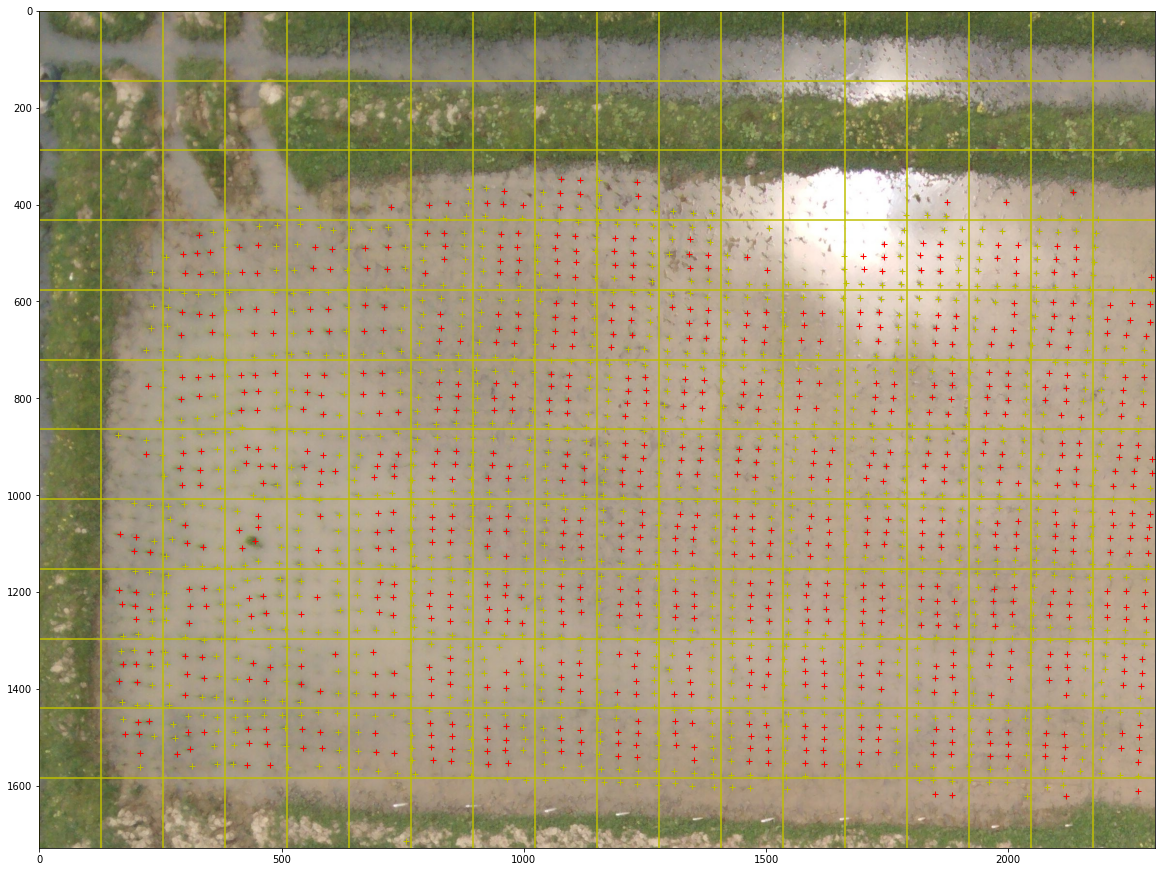

In [15]:
ix = 7

sample_images = [
    r'test_public\DSC081034.JPG',
    r'test_public\DSC080633.JPG', 
    r'test_public\DSC080994.JPG',
    r'test_public\DSC082754.JPG',
    r'C:\Users\user\OneDrive\桌面\adiea2\test_public\DSC080823.JPG',
    r'test_private\IMG_170406_040206_0150_RGB2.JPG',
    r'test_private\IMG_170406_035928_0018_RGB4.JPG',
    r'test_public\IMG_170406_040108_0102_RGB1.JPG',
    r'test_private\IMG_170406_035928_0018_RGB4.JPG',
]

zone_width = 25+8 if 'RGB' in sample_images else 25

full_img = Image.open(sample_images[ix])

# here select prediction answer
# sample_label = os.path.join('full_pred_rf22_XX_xmid0z.5', sample_images[ix].split('\\')[-1].split('.')[0]+'.csv') 
# sample_label = os.path.join('Merge8', sample_images[ix].split('\\')[-1].split('.')[0]+'.csv') 
# sample_label2 = os.path.join('full_pred_half_21.5', sample_images[ix].split('\\')[-1].split('.')[0]+'.csv')
# sample_label = os.path.join('secondVGxy', sample_images[ix].split('\\')[-1].split('.')[0]+'.csv')
sample_label = os.path.join('firstVGxy_clear2', sample_images[ix].split('\\')[-1].split('.')[0]+'.csv')
# sample_label = os.path.join('full_pred_rf22_2XX_fxmid0z.5', sample_images[ix].split('\\')[-1].split('.')[0]+'.csv')
# sample_label = os.path.join('full_pred', sample_images[ix].split('\\')[-1].split('.')[0]+'.csv')

plt.figure(figsize=(20,20))
plt.imshow(full_img)

#==========
# with open(sample_label2, 'r') as f:
#     lines = f.readlines()

# for line in lines:
#     a, b = line.strip().split(',')
#     a, b = int(a), int(b)
#     plt.plot(a,b,'g+',alpha=0.3)
#===========

if not 'RGB' in sample_images[ix]:
    stride = (250, 250)
else:
    stride = (128, 144)

start = (0,0)
# start = (int(stride[0]/2), 0)

x_strides = list(range(start[0],full_img.size[0], stride[0]))[:-1]
x_strides.append(full_img.size[0]-stride[0])
y_strides = list(range(start[1],full_img.size[1], stride[1]))[:-1]
y_strides.append(full_img.size[1]-stride[1])

dots = []

with open(sample_label, 'r') as f:
    lines = f.readlines()

for line in lines:
    a, b = line.strip().split(',')
    a, b = int(a), int(b)
    dots.append((a,b))

    if a > x_strides[0]+zone_width and a <= full_img.size[0]-zone_width and (a % stride[0] <= zone_width or a % stride[0] >= stride[0]- zone_width):
        plt.plot(a,b, 'y+', alpha=1)
        radius = 20
        theta = np.linspace( 0 , 2 * np.pi , 150 )
        x = a + radius * np.cos( theta )
        y = b + radius * np.sin( theta )
        # plt.plot(x, y, 'g-')
    elif b > y_strides[1]+zone_width and b <= full_img.size[1]-zone_width and  (b % stride[1] <= zone_width or b % stride[1] >= stride[1]-zone_width):
        plt.plot(a,b, 'y+', alpha=1)
        radius = 20
        theta = np.linspace( 0 , 2 * np.pi , 150 )
        x = a + radius * np.cos( theta )
        y = b + radius * np.sin( theta )
        # plt.plot(x, y, 'g-')
    else:
        plt.plot(a,b,'r+',alpha=1)

for x_stride in x_strides:
    plt.plot([x_stride, x_stride], [0, 2000], 'y-')
for y_stride in y_strides:
    plt.plot([0, 3000], [y_stride, y_stride], 'y-')

plt.xlim([0, full_img.size[0]])
plt.ylim([full_img.size[1], 0])

# for i in range(1, len(x_strides)):
#     plt.axvspan(x_strides[i]-zone_width, x_strides[i]+zone_width, alpha=0.2, color='blue')
# for i in range(1, len(y_strides)):
#     plt.axhspan(y_strides[i]-zone_width, y_strides[i]+zone_width, alpha=0.2, color='blue')

# closest = []
# dclosest = []
# for i in range(len(dots)):
#     d = np.square(np.array(dots)[:,0]-dots[i][0]) + np.square(np.array(dots)[:,1]-dots[i][1])
#     d[i] = 100000
#     closest.append(np.argmin(d))
#     dclosest.append(d[np.argmin(d)])
plt.savefig('./zzzzzzz.png')

<AxesSubplot:ylabel='Frequency'>

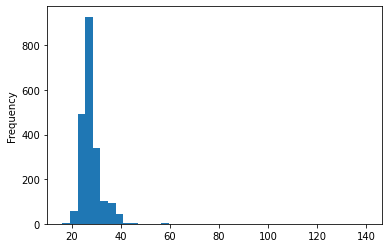

In [14]:
s = pd.Series(np.sqrt(dclosest))
s.plot.hist(bins=40)

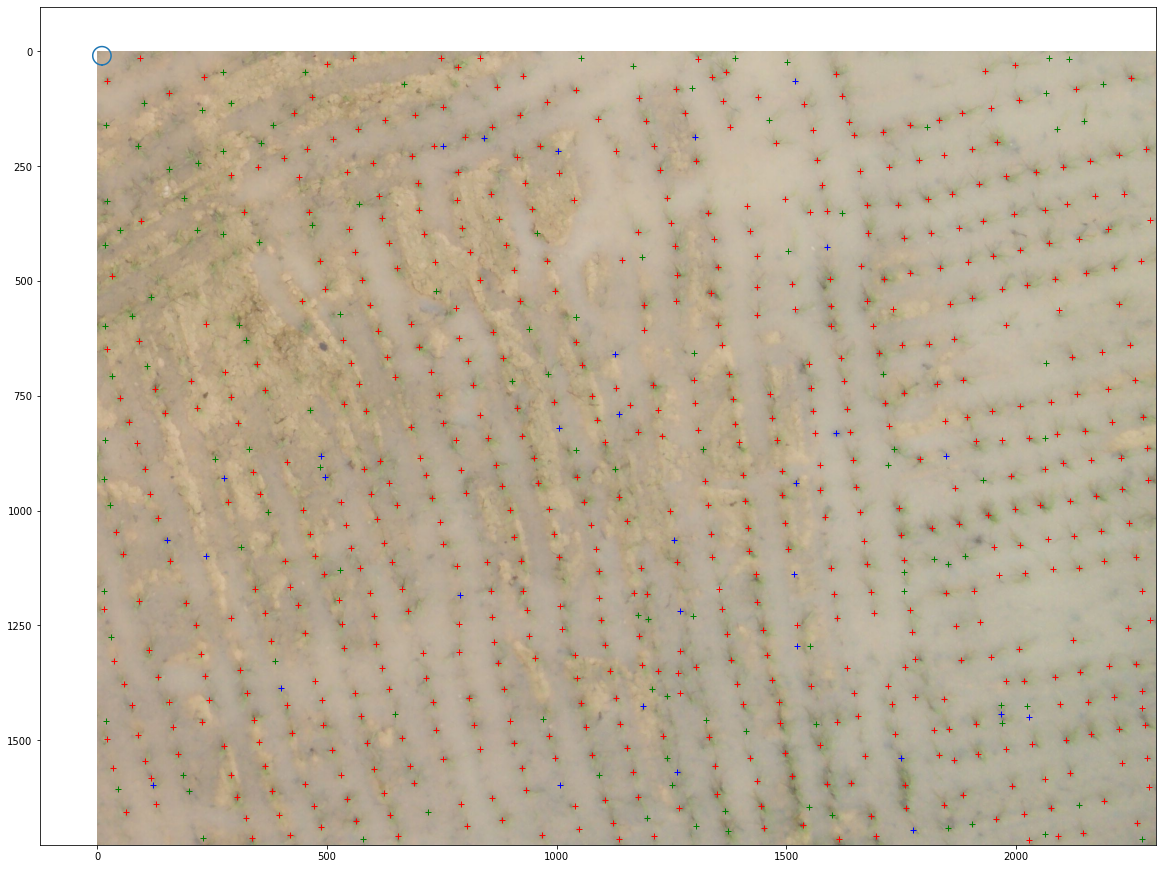

In [4]:
ix = -1
plt.figure(figsize=(20,20))
full_img = Image.open(sample_images[ix])
plt.imshow(full_img)
fnl = sample_images[ix].split('\\')[-1].split('.')[0]+'.csv'
fpl1 = r'full_pred_vni_rf2/' + fnl
fpl2 = r'full_pred_vague_norep4_intersect/' + fnl

with open(fpl1, 'r') as f:
    lines1 = f.readlines()

with open(fpl2, 'r') as f:
    lines2 = f.readlines()

lines1.sort(key=lambda x:x.strip().split(',')[0])

lines2.sort(key=lambda x:x.strip().split(',')[0])


for line1 in lines1:
    
    PAIR = False
    for line2 in lines2:
        x1,y1 = line1.strip().split(',')
        x1,y1 = int(x1), int(y1)

        x2,y2 = line2.strip().split(',')
        x2, y2 = int(x2), int(y2)
    
        if (x1-x2)**2 + (y1-y2)**2 <= 360:
            PAIR = True
            plt.plot(x1, y1, 'r+')
            break

    if PAIR == True:
        lines2.remove(line2)
    else:
        plt.plot(x1, y1, 'b+')

for line2 in lines2:

    x2,y2 = line2.strip().split(',')
    x2, y2 = int(x2), int(y2)
    plt.plot(x2,y2,'g+')

s = np.linspace(0,2*np.pi)
a = 20*np.sin(s) + 10
b = 20*np.cos(s) + 10

plt.plot(a, b)


In [43]:
# d = r'full_pred_vni_rf2.4'
# outdir = r'./dep'
# os.mkdir(outdir)

# for fname in os.listdir(d):

#     with open(os.path.join(d, fname), 'r') as f:
#         lines = f.readlines()


#     # 21 days image size (2304, 1728)
#     if 'RGB' in fname:
#         stride = (256, 288)
#         x_strides = list(range(0, 2304, 256))
#         y_strides = list(range(0, 1728, 288))
#     # 48 days image size (3000, 2000)
#     else:
#         stride = (250, 250)
#         x_strides = list(range(0, 3000, 250))
#         y_strides = list(range(0, 2000, 250))

#     xys = []
#     for line in lines:
#         x, y = line.strip().split(',')
#         xys.append((int(x), int(y)))

#     dxys = dict()
#     for x_stride in x_strides:
#         for y_stride in y_strides:
            
#             rm_list = []
#             for xy in xys:
#                 x, y = xy
#                 if x>=x_stride and x<x_stride+stride[0] and y>=y_stride and y<y_stride+stride[1]:
#                     key = str(x_stride) + '_' + str(y_stride)
#                     if not key in list(dxys.keys()):
#                         dxys[key] = []

#                     dxys[key].append((x,y))
#                     rm_list.append((x,y))

#             for rm in rm_list:
#                 xys.remove(rm)

#     with open(os.path.join(outdir, fname), 'w') as f:
#         for key in list(dxys.keys()):

#             if len(dxys[key]) >= 3:

#                 for xy in dxys[key]:
#                     f.write('{},{}\n'.format(xy[0], xy[1]))


In [10]:
# based on dir1 append dir2
def merge2(dir1, dir2, dirOut):

    os.mkdir(dirOut)

    for fn1, fn2 in zip(sorted(os.listdir(dir1)), sorted(os.listdir(dir2))):

        fp1 = os.path.join(dir1, fn1)
        fp2 = os.path.join(dir2, fn2)
        fpOut = os.path.join(dirOut, fn1)

        with open(fp1, 'r') as f:
            lines1 = f.readlines()
        with open(fp2, 'r') as f:
            lines2 = f.readlines()

        lines1.sort(key=lambda x:x.strip().split(',')[0])
        lines2.sort(key=lambda x:x.strip().split(',')[0])

        with open(fpOut, 'w') as fout:
            for line1 in lines1:
                
                PAIR = False
                for line2 in lines2:
                    x1,y1 = line1.strip().split(',')
                    x1,y1 = int(x1), int(y1)

                    x2,y2 = line2.strip().split(',')
                    x2, y2 = int(x2), int(y2)
                
                    if (x1-x2)**2 + (y1-y2)**2 <= 360:
                        PAIR = True
                        fout.write('{},{}\n'.format(x1,y1))
                        break

                if PAIR == True:
                    lines2.remove(line2)
                else:
                    fout.write('{},{}\n'.format(x1,y1))

            for line2 in lines2:

                x2,y2 = line2.strip().split(',')
                fout.write('{},{}\n'.format(x2,y2))


In [40]:
def vagueMerge(base, vg, dirOut, zone_width=25, c='x'):

    os.mkdir(dirOut)
    
    for fnbase, fnvg in zip(sorted(os.listdir(base)), sorted(os.listdir(vg))):

        if 'RGB' in fnbase:
            stride = (256, 288)
        else:
            stride = (250, 250)

        fpbase = os.path.join(base, fnbase)
        fpvg = os.path.join(vg, fnvg)
        fpOut = os.path.join(dirOut, fnbase)

        with open(fpbase, 'r') as f:
            lines1 = f.readlines()
        with open(fpvg, 'r') as f:
            lines2 = f.readlines()

        with open(fpOut, 'w') as fout:

            for line1 in lines1:
                x1, y1 = line1.strip().split(',')
                x1, y1 = int(x1), int(y1)

                if c == 'x':
                    t = x1
                    i = 0
                else:
                    t = y1
                    i = 1

                if not ((t % stride[i] <= zone_width or t % stride[i] >= stride[i]-zone_width) and t>zone_width):
                    fout.write('{},{}\n'.format(x1,y1))

            for line2 in lines2:
                x2, y2 = line2.strip().split(',')
                x2, y2 = int(x2), int(y2)
                
                if c == 'x':
                    t = x2
                    i = 0
                else:
                    t = y2
                    i = 1
        
                if ((t % stride[i] <= zone_width or t % stride[i] >= stride[i]-zone_width) and t>zone_width):
                    fout.write('{},{}\n'.format(x2,y2))

In [14]:
base = r'full_pred_vni_rf32_XX.4'
vg = r'full_pred_rf22_XX_xmid0z.5'
dirOut = r'firstVG'

vagueMerge(base, vg, dirOut, c='x')

base = r'firstVG'
vg = r'full_pred_rf22_XX_ymid0z.5'
dirOut = r'firstVGxy'

vagueMerge(base, vg, dirOut, c='y')

In [41]:
base = r'full_pred_vni_rf32_XX.4'
vg = r'full_pred_rf22_2XX_fxmid0z.5'
dirOut = r'secondVG'

vagueMerge(base, vg, dirOut, c='x')

base = r'secondVG'
vg = r'full_pred_rf22_2XX_fymid0z.5'
dirOut = r'secondVGxy'

vagueMerge(base, vg, dirOut, c='y')

In [22]:
root = r'./firstVGxy'

yrep, nrep = 0, 0

for l in os.listdir(root):

    with open(os.path.join(root, l)) as f:
        lines = f.readlines()

    dots = []

    for line in lines:
        x, y = line.strip().split(',')
        x, y = int(x), int(y)

        dots.append((x,y))

    dots = list(set(dots))

    with open(os.path.join(root, l), 'w') as f:
        for dot in dots:
            f.write('{},{}\n'.format(dot[0], dot[1]))    

In [43]:
def reduction(root, dirOut, thresh=15):

    os.mkdir(dirOut)

    for l in os.listdir(root):

        with open(os.path.join(root, l)) as f:
            lines = f.readlines()
        
        dots = []

        for line in lines:
            x, y = line.strip().split(',')
            x, y = int(x), int(y)

            dots.append((x,y))

        closest = []
        dclosest = []
        for i in range(len(dots)):
            d = np.square(np.array(dots)[:,0]-dots[i][0]) + np.square(np.array(dots)[:,1]-dots[i][1])
            d[i] = 1000000
            closest.append(np.argmin(d))
            dclosest.append(d[np.argmin(d)])

        rm_points = []
        new_points = []
        paired_ids = set()
        for idx1 ,(idx2, d) in enumerate(zip(closest, np.sqrt(dclosest))):  
            if d < thresh and (not idx1 in paired_ids) and (not idx2 in paired_ids):
                rm_points.append(dots[idx1])
                rm_points.append(dots[idx2])
                paired_ids.add(idx1)
                paired_ids.add(idx2)
                new_points.append( ( (dots[idx1][0]+dots[idx2][0])/2 , (dots[idx1][1]+dots[idx2][1])/2 ) )

        for rm_point in rm_points:
            dots.remove(rm_point)
        for new_point in new_points:
            dots.append(new_point)

        with open(os.path.join(dirOut, l), 'w') as f:
            for dot in dots:
                f.write('{},{}\n'.format(int(dot[0]), int(dot[1])))

In [14]:
root = r'firstVGxy'
dirOut = r'firstVGxy_clear'

root = r'firstVGxy_clear'
dirOut = r'firstVGxy_clear2'

root = r'firstVGxy_clear'
dirOut = r'firstVGxy_clear3'

reduction(root, dirOut, thresh=20)

In [44]:
root = r'secondVGxy'
dirOut = r'secondVGxy_clear'
reduction(root, dirOut, thresh=20)

root = r'secondVGxy_clear'
dirOut = r'secondVGxy_clear2'
reduction(root, dirOut, thresh=20)

In [11]:
dir1 = r'full_pred_vni_rf2/'
dir2 = r'full_pred_vague_norep4_intersect/'
dirOut = r'Merge1'

dir1 = r'full_pred_vni_+8_rf2/'
dir2 = r'Merge1'
dirOut = r'Merge2'

dir1 = r'full_pred_vni_+8_rf2'
dir2 = r'full_pred_vague_norep4_intersect'
dirOut = r'Merge3'

dir1 = r'full_pred_vni_rf22'
dir2 = r'full_pred_vague_norep4_intersect'
dirOut = r'Merge4'

dir1 = r'full_pred_vni_rf22_48X.4'
dir2 = r'full_pred_vague_norep4_intersect'
dirOut = r'Merge5'

dir1 = r'full_pred_vague_norep4_intersect'
dir2 = r'full_pred_vni_rf22_48X.4'
dirOut = r'Merge5_inv'

dir1 = r'full_pred_vni_rf22_48X.4'
dir2 = r'full_pred_vni_rf22_XX.4'
dirOut = r'Merge6'

dir1 = r'full_pred_vni_rf32_XX.4'
dir2 = r'full_pred_vni_rf22_48X.4'
dirOut = r'Merge7'

dir1 = r'full_pred_vni_rf32_XX.4'
dir2 = r'full_pred_rf22_XX.5'
dirOut = r'Merge8'

merge2(dir1, dir2, dirOut)

In [46]:
# counting difference between no threshold and conf>=0.5

tot = []
name = []

name.append('full_pred')
tot.append(0)
for p in os.listdir(r'C:\Users\user\OneDrive\桌面\adiea2\full_pred'):
    with open(os.path.join(r'C:\Users\user\OneDrive\桌面\adiea2\full_pred', p)) as f:
        tot[-1] += len(f.readlines())


name.append('full_pred_vague_norep4_interesect(current best)' + \
    'p[adaptiver = False, extra_vzone=8]')
tot.append([0,0])
d = r'C:\Users\user\OneDrive\桌面\adiea2\full_pred_vague_norep4_intersect'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())

name.append('full_pred_vni_a+8')
tot.append([0,0])
d = r'C:\Users\user\OneDrive\桌面\adiea2\full_pred_vni_a+8'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())

name.append('full_pred_vni_+8c04')
tot.append([0,0])
d = r'C:\Users\user\OneDrive\桌面\adiea2\full_pred_vni_+8c04'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())

name.append('full_pred_vni_rf2.4')
tot.append([0,0])
d = r'C:\Users\user\OneDrive\桌面\adiea2\full_pred_vni_rf2.4'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())


name.append('Merge8')
tot.append([0,0])
d = r'C:\Users\user\OneDrive\桌面\adiea2\Merge8'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())

name.append('48X.4')
tot.append([0,0])
d = r'full_pred_vni_rf22_48X.4'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())

name.append('32X.4')
tot.append([0,0])
d = r'full_pred_vni_rf32_XX.4'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())


name.append('rz+9')
tot.append([0,0])
d = r'full_pred_rz+9_rf32_XX.4'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())

name.append('xx.5')
tot.append([0,0])
d = r'firstVGxy_clear2'
# d = r'full_pred_rf22_XX.5'
for p in os.listdir(d):
    if 'RGB' in p:
        with open(os.path.join(d, p)) as f:
            tot[-1][0] += len(f.readlines())
    else:
        with open(os.path.join(d, p)) as f:
            tot[-1][1] += len(f.readlines())

for t, n in zip(tot, name):
    print('{}:\n\t{}'.format(n,t))

full_pred:
	129553
full_pred_vague_norep4_interesect(current best)p[adaptiver = False, extra_vzone=8]:
	[44806, 44921]
full_pred_vni_a+8:
	[47765, 44921]
full_pred_vni_+8c04:
	[47746, 46591]
full_pred_vni_rf2.4:
	[47040, 46591]
Merge8:
	[50574, 45688]
48X.4:
	[47040, 45635]
32X.4:
	[44648, 45635]
rz+9:
	[44648, 44774]
xx.5:
	[47104, 44752]


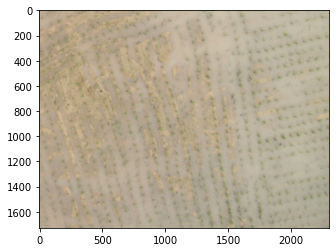

In [7]:
img = Image.open(r'test_private\IMG_170406_035928_0018_RGB4.JPG')
# enhancer = ImageEnhance.Brightness(img)
# img = enhancer.enhance(1.5)
enhancer = ImageEnhance.Sharpness(img)
img = enhancer.enhance(1.7)
plt.imshow(img)

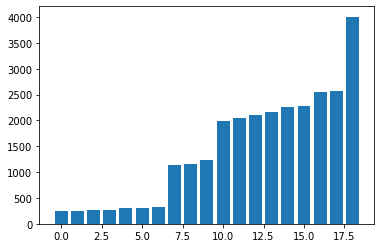

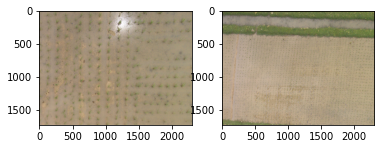

In [36]:
ys = []
fs = []
d = r'Train_Dev\train_labels'
for fn in os.listdir(d):
    if 'RGB' in os.path.join(d,fn):
        with open(os.path.join(d,fn), 'r') as f:
            ys.append(len(f.readlines()))
            fs.append(fn)

fs,ys = zip(*sorted(zip(fs,ys), key=lambda x: x[1]))
plt.bar(range(len(ys)), ys)

d = r'Train_Dev\training'
to_img = lambda x: x.split('.')[0] + '.JPG'

fig, ax = plt.subplots(1,2)

img = Image.open(os.path.join(d, to_img(fs[0])))
ax[0].imshow(img)

img = Image.open(os.path.join(d, to_img(fs[10])))
ax[1].imshow(img)

In [26]:
def easyDraw(ipath, lpath):

    img = Image.open(ipath)
    plt.imshow(img)

    label = read_yolo_label(lpath)

    for l in label:
        
        c, xc, yc, w, h, conf = l
        xc = float(xc) * img.size[0]
        yc = float(yc) * img.size[1]

        plt.plot(xc, yc, 'r+')

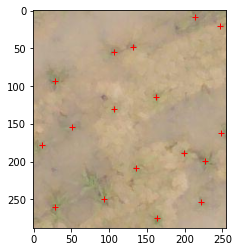

In [27]:
ipath = r'full_source_xmid\af21ds\IMG_170406_035928_0018_RGB4_128_0.JPG'
lpath = r'full_source_xmid\af21ds\labels_rf3_X\IMG_170406_035928_0018_RGB4_128_0.txt'

easyDraw(ipath, lpath)

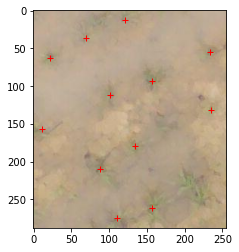

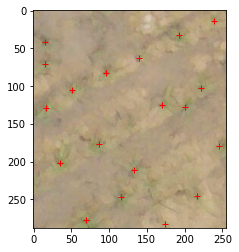

In [29]:
lpath = r'full_source\af21ds\labels_rf3_X\IMG_170406_035928_0018_RGB4_0_0.txt'
ipath = r'full_source\af21ds\IMG_170406_035928_0018_RGB4_0_0.JPG'
easyDraw(ipath, lpath)

plt.figure()

lpath = r'full_source\af21ds\labels_rf3_X\IMG_170406_035928_0018_RGB4_0_288.txt'
ipath = r'full_source\af21ds\IMG_170406_035928_0018_RGB4_0_288.JPG'
easyDraw(ipath, lpath)

In [19]:
2*(0.906*0.867)/(0.906+0.867)

0.8860710659898476